In [1]:
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols
import wooldridge
from see import see
import matplotlib.pyplot as plt
from numba import njit
from scipy.stats import norm, uniform, gaussian_kde, multivariate_normal
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from pandas.plotting import scatter_matrix
import seaborn as sns

In [2]:
wage1 = wooldridge.data('wage1').loc[:,['wage', 'educ', 'tenure', 'exper']]

In [3]:
wooldridge.data('wage1',description=True)

name of dataset: wage1
no of variables: 24
no of observations: 526

+----------+---------------------------------+
| variable | label                           |
+----------+---------------------------------+
| wage     | average hourly earnings         |
| educ     | years of education              |
| exper    | years potential experience      |
| tenure   | years with current employer     |
| nonwhite | =1 if nonwhite                  |
| female   | =1 if female                    |
| married  | =1 if married                   |
| numdep   | number of dependents            |
| smsa     | =1 if live in SMSA              |
| northcen | =1 if live in north central U.S |
| south    | =1 if live in southern region   |
| west     | =1 if live in western region    |
| construc | =1 if work in construc. indus.  |
| ndurman  | =1 if in nondur. manuf. indus.  |
| trcommpu | =1 if in trans, commun, pub ut  |
| trade    | =1 if in wholesale or retail    |
| services | =1 if in services indus.  

In [4]:
formula_1 = 'np.log(wage) ~ educ + tenure + exper'

In [5]:
res_1 = ols(formula_1, data=wage1).fit()

In [6]:
see(res_1)

    <                    <=                   ==                   !=
    >                    >=                   dir()                hash()
    help()               repr()               str()                .HC0_se
    .HC1_se              .HC2_se              .HC3_se              .aic
    .bic                 .bse                 .centered_tss
    .compare_f_test()    .compare_lm_test()
    .compare_lr_test()                        .condition_number    .conf_int()
    .conf_int_el()       .cov_HC0             .cov_HC1             .cov_HC2
    .cov_HC3             .cov_kwds            .cov_params()        .cov_type
    .df_model            .df_resid            .eigenvals           .el_test()
    .ess                 .f_pvalue            .f_test()
    .fittedvalues        .fvalue              .get_influence()
    .get_prediction()    .get_robustcov_results()
    .initialize()        .k_constant          .llf                 .load()
    .model               .mse_model           .mse_

In [7]:
res_1.params

Intercept    0.284360
educ         0.092029
tenure       0.022067
exper        0.004121
dtype: float64

In [8]:
res_1.params[1]

0.09202898676928312

In [9]:
wm = wage1.mean()  # 変数の平均の計算
wm

wage       5.896103
educ      12.562738
tenure     5.104563
exper     17.017110
dtype: float64

In [10]:
wm['educ']

12.562737642585551

In [11]:
z = pd.DataFrame({'educ':[wm['educ']],
                  'tenure':[wm['tenure']],
                  'exper':[wm['exper']]})

In [12]:
res_1.predict(z)

0    1.623268
dtype: float64

In [13]:
educ_mean = wm['educ']
tenure_mean = wm['tenure']
exper_mean = wm['exper']

z2 = pd.DataFrame({'educ':[educ_mean*0.5, educ_mean, educ_mean*1.5],
                  'tenure':[tenure_mean]*3,
                  'exper':[exper_mean]*3})
res_1.predict(z2)

0    1.045200
1    1.623268
2    2.201336
dtype: float64

In [14]:
len(wage1) == (res_1.predict() == res_1.fittedvalues).sum()

True

In [15]:
formula_2 = 'np.log(wage) ~ educ + tenure + exper + I(exper**2)'
res_2 = ols(formula_2, data=wage1).fit()

In [16]:
res_2.params

Intercept        0.198345
educ             0.085349
tenure           0.020841
exper            0.032854
I(exper ** 2)   -0.000661
dtype: float64

In [17]:
def myfunc(x):
    return x**2

In [18]:
formula_3 = 'np.log(wage) ~ educ + exper + tenure + myfunc(exper)'
res_3 = ols(formula_3, data=wage1).fit()

In [19]:
res_3.params

Intercept        0.198345
educ             0.085349
exper            0.032854
tenure           0.020841
myfunc(exper)   -0.000661
dtype: float64

In [20]:
formula_1a = 'wage ~ educ + tenure + exper'
res_1a = ols(formula_1a, data=wage1).fit()
res_1a.params

Intercept   -2.872735
educ         0.598965
tenure       0.169269
exper        0.022340
dtype: float64

In [21]:
res_1.scale

0.19435933207482123

In [22]:
SSR = res_1.ssr  # 残差の二乗平方和
n = res_1.nobs
k = res_1.df_model
SSR/(n-k-1)

0.19435933207482123

In [23]:
res_1.bse

Intercept    0.104190
educ         0.007330
tenure       0.003094
exper        0.001723
dtype: float64

In [24]:
n = 30  # 標本の大きさ
b0 = 1  # 定数項
b1 = 2  # x1の係数
b2 = 3  # x2の係数

In [25]:
x1 = np.random.normal(loc=4.0, scale=2.0, size=n)  # (1)の説明

x2 = np.random.uniform(low=1.0, high= 10.0, size=n)  # (2)の説明

u = np.random.normal(loc=0, scale=1.0, size=n)  # (1)の説明

y = b0 + b1*x1 + b2*x2 + u

c = np.ones(n)  # (3)の説明

In [26]:
X = np.stack([c,x1,x2],axis=1)
X.shape

(30, 3)

In [27]:
bhat = np.linalg.inv((X.T)@X)@(X.T)@y
bhat

array([0.71090233, 2.01837687, 3.05612489])

In [28]:
df_check = pd.DataFrame({'Y':y,'X1':x1,'X2':x2})
ols('Y ~ X1 + X2', data=df_check).fit().params

Intercept    0.710902
X1           2.018377
X2           3.056125
dtype: float64

In [29]:
N = 100_000
b0=1.0
b1=2.0
b2=3.0

In [30]:
@njit  # 計算の高速化
def sim_unbias(n):  # n=標本の大きさ

    # 推定値を格納するarray
    b0hat_arr = np.zeros(N)
    b1hat_arr = np.zeros(N)
    b2hat_arr = np.zeros(N)
    
    c = np.ones(n)  # 定数項
    
    for i in range(N):  # N 回のループ
        
        # 標準正規分布
        u = np.random.normal(loc=0, scale=1.0, size=n)
        
        # 平均4.0,標準偏差2.0の正規分布
        x1 = np.random.normal(loc=4, scale=2.0, size=n)
        
        # [1,10)の一様分布。`low=`，`high=`を付け加えるとエラーが発生する。
        x2= np.random.uniform(1.0, 10.0, size=n)
        
        y = b0 + b1*x1 + b2*x2 + u  # 説明変数
        
        X = np.stack((c,x1,x2),axis=1)  # 説明変数の行列
        bhat = np.linalg.inv((X.T)@X)@(X.T)@y  # OLS推定
        
        b0hat_arr[i] = bhat[0]
        b1hat_arr[i] = bhat[1]
        b2hat_arr[i] = bhat[2]
        
    return b0hat_arr, b1hat_arr, b2hat_arr

In [31]:
b0hat, b1hat, b2hat = sim_unbias(30)

In [32]:
print('b0:', sum(b0hat)/len(b0hat),
      '\nb1:', sum(b1hat)/len(b1hat),
      '\nb1:', sum(b2hat)/len(b2hat))

b0: 1.0014376947676085 
b1: 1.9995557381972482 
b1: 3.000100668219681


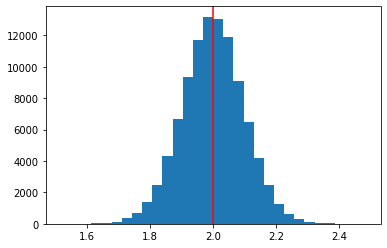

In [33]:
plt.hist(b1hat,bins=30)
plt.axvline(x=b1,color='red')
pass

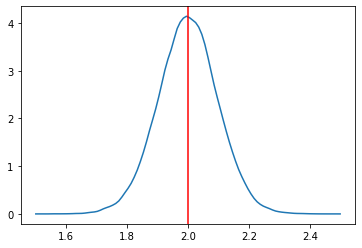

In [34]:
x=np.linspace(1.5,2.5,100)  # 図を作成するために-0.5から1.5までの横軸の値を設定
kde_model=gaussian_kde(b1hat)  # bhatのカーネル密度推定を設定
ufunc = kde_model(x)  # カーネル密度推定を使いb1hatの分布を推定

plt.plot(x, ufunc)  # 誤差項の分布をプロット
plt.axvline(x=b1,color='red')  # 母集団のパラメータ
pass

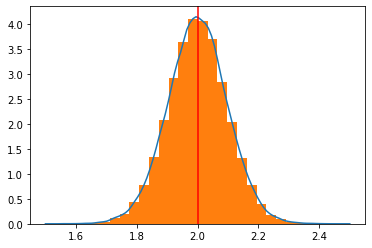

In [35]:
x=np.linspace(1.5,2.5,100)
kde_model=gaussian_kde(b1hat)
ufunc = kde_model(x)

plt.plot(x, ufunc)
plt.hist(b1hat,bins=30, density=True)
plt.axvline(x=b1,color='red')
pass

In [36]:
wage1_vif = wage1.drop('wage', axis=1)

In [37]:
mc = wage1_vif.corr().values

In [38]:
vif_manual = np.linalg.inv(mc).diagonal()
vif_manual

array([1.11277075, 1.34929556, 1.47761777])

In [39]:
pd.Series(vif_manual, index=wage1_vif.columns)

educ      1.112771
tenure    1.349296
exper     1.477618
dtype: float64

In [40]:
def my_vif(dataframe):
    mc = dataframe.corr().values
    vif = np.linalg.inv(mc).diagonal()
    return pd.Series(vif_manual, index=dataframe.columns)

my_vif(wage1_vif)

educ      1.112771
tenure    1.349296
exper     1.477618
dtype: float64

In [41]:
wage1_vif['Intercept'] = 1.0

In [42]:
for i in range(len(wage1_vif.columns)-1):  # 定数項は無視するために-1
    print(wage1_vif.columns[i], '\t',vif(wage1_vif.values, i))

educ 	 1.1127707502838835
tenure 	 1.3492955605611776
exper 	 1.4776177726317783


In [43]:
def sim_multi(n, N, m):  # n=標本の大きさ, N=標本数, m=共分散
    
    # ２つのx1,x2の共分散を設定
    rv_mean = [4, 1]  # x1, x2の平均
    # x1, x2の共分散行列
    rv_cov = [[1.0, m],    # 全ての変数の分散は１（対角成分）
               [m, 1.0]]  # Cov(x1,x2)=m
    
    # 推定値を入れる空のリスト
    b0hat_arr = np.zeros(N)
    b1hat_arr = np.zeros(N)
    b2hat_arr = np.zeros(N)
    
    c = np.ones(n)  # 定数項
    
    for i in range(N):  # N 回のループ
        
        # x1, x2の値の抽出
        rv = multivariate_normal.rvs(rv_mean, rv_cov, size=n)  # x1, x2,をnセット抽出
        x1 = rv[:,0]  # 説明変数
        x2 = rv[:,1]  # 説明変数

        u = np.random.randn(n)  # 標準正規分布
        y = b0 + b1*x1 + b2*x2 + u  # 説明変数
        
        X = np.stack((c,x1,x2),axis=1)  # 説明変数の行列
        bhat = np.linalg.inv((X.T)@X)@(X.T)@y  # OLS推定
        
        b0hat_arr[i] = bhat[0]  # b0hat_listへの追加
        b1hat_arr[i] = bhat[1]  # b1hat_listへの追加
        b2hat_arr[i] = bhat[2]  # b2hat_listへの追加

    return b0hat_arr, b1hat_arr, b2hat_arr # 返り値の設定

In [44]:
# 多重共線性が弱いケース 
b0hat_weak, b1hat_weak, b2hat_weak = sim_multi(30, 10_000, m=0.1)

# 多重共線性が強いケース 
b0hat_strong, b1hat_strong, b2hat_strong = sim_multi(30, 10_000, m=0.9)

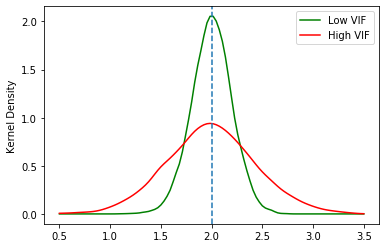

In [45]:
xx=np.linspace(0.5,3.5,num=100)  # 図を作成するために横軸の値を設定

# 多重共線性が弱いケース
kde_model_weak=gaussian_kde(b1hat_weak)  # OLS推定量のカーネル密度関数を計算

# 多重共線性が強いケース
kde_model_strong=gaussian_kde(b1hat_strong)

plt.plot(xx, kde_model_weak(xx), 'g-', label='Low VIF')  # OLS推定量の分布プロット
plt.plot(xx, kde_model_strong(xx),'r-', label='High VIF')  # IV推定量の分布プロット
plt.axvline(x=b1,linestyle='dashed')
plt.ylabel('Kernel Density')  # 縦軸のラベル
plt.legend()  # 凡例
pass

In [46]:
np.var(b1hat_weak), np.var(b1hat_strong)

(0.039780765539978315, 0.1978348066231052)

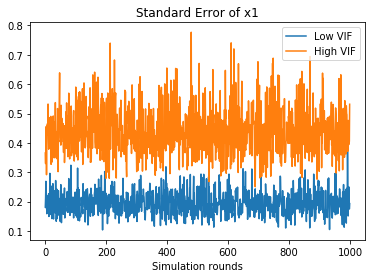

In [47]:
def sim_se(n, N, m, b0=1.0, b1=0.5, b2=1.5):  # n=標本の大きさ, N=標本数, m=共分散
    
    rv_mean = [4, 1]  # x1, x2の平均
    # x1, x2の共分散行列
    rv_cov = [[1.0, m],    # 全ての変数の分散は１（対角成分）
              [m, 1.0]]  # Cov(x1,x2)=m
    
    # 推定値を入れるarray
    se_x1_arr = np.zeros(N)
    se_x2_arr = np.zeros(N)

    for i in range(N):  # N 回のループ
        
        rv = multivariate_normal.rvs(rv_mean, rv_cov, size=n)  # x1, x2,をnセット抽出
        x1 = rv[:,0]  # 説明変数
        x2 = rv[:,1]  # 説明変数
        X = np.stack([np.ones(n),x1,x2],axis=1)  # 説明変数の行列    
        
        u = np.random.normal(loc=0, scale=1, size=n)  # 誤差項（標準正規分布）
        y = b0 + b1*x1 + b2*x2 + u  # 説明変数

        bhat = np.linalg.inv((X.T)@X)@(X.T)@y # 係数の推定値
        yhat = X@bhat  # yの予測値
        uhat = y-yhat  # 残差
        rss = (uhat.T)@uhat  # 残差平方和
        sigma2 = rss/(n-3)  # 回帰の残差（不偏）分散 
        XTX_1 = np.linalg.inv(X.T@X)  # moment matrix
        variance = sigma2*np.diag(XTX_1)  # bの分散
        se = np.sqrt(variance)  # bの標準誤差
        
        se_x1_arr[i] = se[1]  # arrayに追加
        se_x2_arr[i] = se[2]  # array追加
        
    return se_x1_arr, se_x2_arr # 返り値の設定


# 多重共線性が弱いケース 
se_x1_weak, se_x1_weak = sim_se(30,1000,m=0.1)

# 多重共線性が強いケース 
se_x1_strong, se_x1_strong = sim_se(30,1000,m=0.9)


plt.plot(se_x1_weak, label='Low VIF')
plt.plot(se_x1_strong, label='High VIF')
plt.title('Standard Error of x1')
plt.xlabel('Simulation rounds')
plt.legend()
pass

In [48]:
sum(se_x1_weak)/len(se_x1_weak), sum(se_x1_strong)/len(se_x1_strong)

# 次のコードでもOK
# np.array(se_x1_weak).mean(), np.array(se_x1_strong).mean()

(0.19483832918828456, 0.44156795126691556)

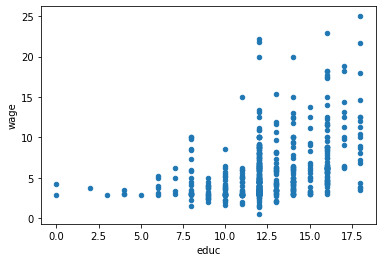

In [49]:
wage1.plot.scatter('educ','wage')
pass

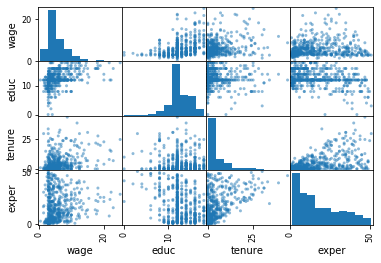

In [50]:
scatter_matrix(wage1)
pass

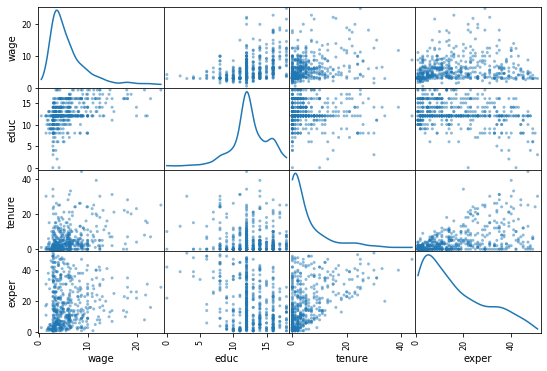

In [51]:
scatter_matrix(wage1, figsize=(9, 6), diagonal='kde')
pass

In [52]:
mat = wage1.corr()
mat

,wage,educ,tenure,exper
wage,1.000000,0.405903,0.346890,0.112903
educ,0.405903,1.000000,-0.056173,-0.299542
tenure,0.346890,-0.056173,1.000000,0.499291
exper,0.112903,-0.299542,0.499291,1.000000


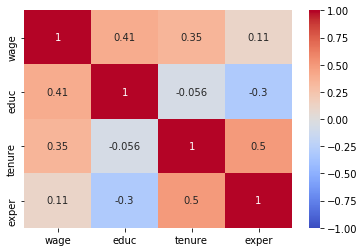

In [53]:
sns.heatmap(mat, vmin=-1, annot=True, cmap='coolwarm')
pass

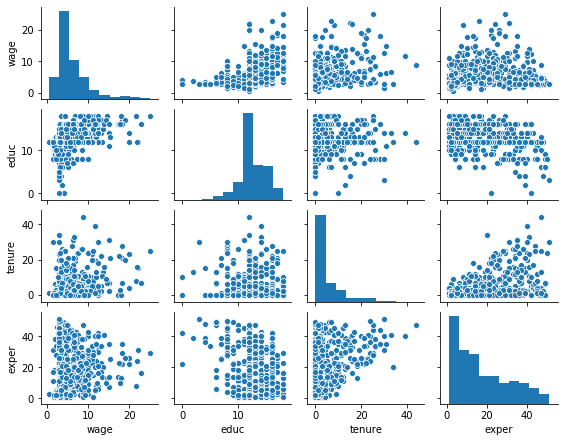

In [54]:
sns.pairplot(wage1, height=1.5, aspect=1.3)
pass